# Algorithme de PageRank

## Introduction 

En 2019, le nombre de sites Internet s'élève à plus 1,7 milliard, d'après les statistiques annuelles obtenues par NetCraft et l'algorithme Worldmeters. Néanmoins, derrière ce chiffre impressionnant, le nombre de sites web considérés comme actifs ne s'élève qu'à moins de 200 millions.

Lorsque nous effectuons une recherche sur Google, on peut se demander comment Google classe les résultats de cette requête, au vu du grand nombre de données disponibles. En fait, il va utiliser une mesure de la qualité ou de la popularité des pages web (PageRank) pour classer les résultats par ordre de pertinence.

Le web peut être vu comme un graphe dirigé G(V,E) où les sommets V sont les pages web et les arcs E sont les hyperliens entre les pages. Les arcs partent de la page où se trouve le lien et vont vers la page indiquée. La présence d'un lien vers une certaine page constitue un "vote" en faveur de cette page. Le PageRank est donc une mesure de l'importance relative d'une page sur le web. Cette valeur est basée sur plusieurs principes : 
- Les pages recevant plus de liens sont plus importantes 
- Un lien en provenance d'une page " importante" est plus significatif qu'un lien en provenance d'une page peu importante 
- Si une page contient beaucoup de liens, chaque lien a moins de valeur. 

Plus formellement, le PageRank P de la page n est défini de la façon suivante : <br/>
$$ P(n) = \alpha ( \frac{1}{|G|} ) + (1-\alpha) \sum_{m \in L(n) } \frac{P(m)}{C(m)}$$

où |G| est le nombre total de noeuds ( ou de pages) dans le graphe,  <br/>
 $\alpha$ est le facteur aléatoire de "saut", <br/>
 L(n) est l'ensemble des pages liées à n , <br/>
 C(m) est le nombre de liens sur la page m, <br/>
 
Dans ce sens, l'ensemble des PageRank des L(n) pages vont altérer le PageRank de n. En effet, en étant sur une page m de L(n), la probabilité d'arriver sur la page n est de $\frac{1}{C(m)}$. Puisque le PageRank de m est la probabilité d'être en m, la probabilité d'arriver à n en étant à m est de $\frac{P(m)}{C(m)}$

In [1]:
# Importation des packages 
import numpy as np
from numpy import *
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import itertools
import networkx as nx

### Etape 1 : Modélisation du web 
On veut que le web soit modélisé de sorte à ce que chaque page soit associée à d'autres pages par un dictionnaire
Puisque les pages n'ont pas forcement de lien entre elles, la matrice de liaison est composée de multiples 0. On veut donc une distribution de probabilité qui favorise la valeur 0. On selectionne random.zipf en le tronquant à n ( taille de la population ) pour que le nombre de pages liées à la page k ne puisse pas être plus grand que le nombre de pages total.

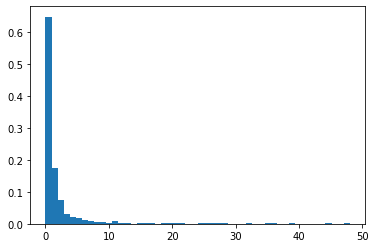

In [2]:
# Distribution de la fonction random.zipf(2,1000)
s = np.random.zipf(2, 1000)-1
count, bins, ignored = plt.hist(s[s<50], 50, density=True)
plt.show()

In [3]:
class web:
    '''
    Définition d'une classe pour modéliser le web
    
    Input :
        - n : taille du web 
    
    Output : 
        - class web
    '''
    def __init__(self,n):
        self.size = n # Taille du web
        self.in_links = {} # Dictionnaire vide des pages se référant à la page i ( pour i allant de 0 à n )
        self.number_out_links = {} # Dictionnaire vide des pages référencées par i ( pour i allant de 0 à n)
        self.dangling_pages = {} # Dictionnaire vide des pages ne se reférant à aucune autre
        for j in range(n): # Préparation des dictionnaires
            self.in_links[j] = []
            self.number_out_links[j] = 0
            self.dangling_pages[j] = True
        self.matrixG = np.zeros((n,n)) # création de la matrice de représentaiton du web (taille nxn )


def random_web(n=1000):
    '''Fonction de modélisation du web
    Input : 
        - n : taille du réseau
        
    Output : 
        - g de class web
    '''
    g = web(n)
    for k in range(n):
        # Nombre aléatoire de liens qui se référent à la page k :
        number_link_k = min(np.random.zipf(2)-1,n) # min pour ne pas obtenir d'échantillon plus grand que l'ensemble de la population
        # Nom des pages qui se référent à la page k
        values = random.sample(range(n),number_link_k)
        # Pages qui citent k 
        g.in_links[k] = values
        # mise à jour de la matrice représentative du web
        for j in values: 
            # mise à jour de la matrice représentative du web
            g.matrixG[j,k]=1
            # mise à jour des dangling pages
            if g.number_out_links[j] == 0: 
                g.dangling_pages.pop(j)
            # mise à jour du nombre de liens de sortie
            g.number_out_links[j] += 1
    return g

In [4]:
# Pour exemple, on définit un réseau de 3000 pages
g=random_web(3000)

### Etape 2 : Algorithmes de PageRank simples

In [5]:
def get_matrice (g):
    '''
    Description matricielle du web, avec les poids de chaque page. 
    
    Input : 
        - g de type web
        
    Output : 
        - G : matrice représentative du web
        
    Exemple : 
        - g=random_web(5)
        - g.in_links 
        >>> {0: [3, 0, 4, 2, 1], 1: [0], 2: [], 3: [], 4: []}
        - get_matrice(g)
        >>> array([[0.5, 0.5, 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ],
                   [1. , 0. , 0. , 0. , 0. ]])
    
    '''
    A = g.matrixG.copy()
    # On adapte pour les noeuds qui n'ont pas de sortie ( sinon division par 0 ): 
    is_dangling= np.sum(A, axis=1)==0
    # Noeuds sans sortie : le web surfeur se téléporte vers un autre noeud de façon aléatoire : 
    B = (np.ones_like(A) - np.identity(g.size)) / (g.size-1) 
    A[is_dangling,:] += B[is_dangling,:]
    # Attribution des poids
    D_inv= np.diag(1/np.sum(A, axis=1))
    G=D_inv@A
    return G
get_matrice(g)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Representation graphique du web

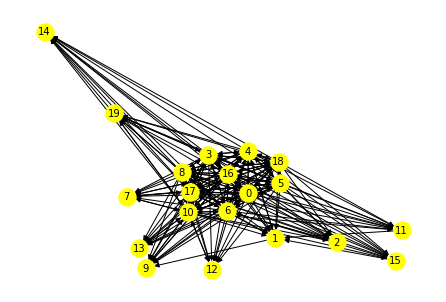

In [6]:
# Exemple d'un réseau composé de 20 noeuds ( pages )
g_d=random_web(20)
G = nx.DiGraph(get_matrice(g_d))
nx.draw(G,with_labels=True,font_color='black',font_size=10,node_color='yellow')

Soit n pages et p = ($p_1$ , ... , $p_n$ ) la distribution de probabilité des pages.

Soit G la matrise de représentation des liens aléatoires entre les pages ( donnée par la fonction get_matrice () ). 
$$
G_{jk} = \begin{cases} \frac{1}{\#(k)}, & \text{si la page k est liée à la page j} \\ 0, & \text { si la page k n'est pas liée à la page j }   \end{cases}
$$
On suppose que si la page k n'a aucun lien de sortie ( dangling node ) alors le web surfeur ira sur n'importe quelle autre page avec probabilité $\frac{1}{n}$. C'est à dire $G_{jk} = \frac{1}{n} $ pour tout j.

La matrice E représente la matrice de téléportation. Elle téléporte le websurfer de la page k à la page j avec probabilité $\frac{1}{n}$. C'est à dire $E_{jk} =\frac{1}{n}$. 

Le websurfer a donc deux possibilités : 
- Avec probabilité s, il suit un lien aléatoire depuis la page où il se trouve, 
- Avec probabilité d = 1-s, il change totalement de chemin en se téléportant vers une autre page. 

Comme dans le papier initial de la publication de PageRank([The anatomy of a large-scale hypertextual Web search engine - Sergey Brin, Lawrence Page - 1998](https://snap.stanford.edu/class/cs224w-readings/Brin98Anatomy.pdf )), on choisira s = 0,85 et d = 0,15. 

Après une étape on arrive donc à : 
M = sG + dE

#### Algorithme 1 : Décomposition en valeurs propres
**Définition matrice de Markov ( ou stochastique ) :** Matrice de taille n x n à valeurs $m_{ij}$ réelles telle que : 
- $0 \le m_{ij} \le 1 $
- Toutes les colonnes sont sommées à 1 : $ \sum_i m_{ij} = 1 $ pour tous j
- Chaque ligne a au moins une valeur non nulle
- Certaines colonnes ont plus d'une entrée non nulle 

La valeur $m_{ij}$ est la probabilité d'aller au i-ième stade en partant du stade j.

La matrice inverse de get_matrice(g) est une matrice de Markov. Ainsi, $M = (1-d)G + dE$ ( avec G la transposée de get_matrice(g)) est de Markov. De plus, c'est une matrice inversible.


Donc, d'après le [**Théorème de Perron Frobenius**](https://sites.math.northwestern.edu/~clark/354/2002/perron.pdf), la matrice M est à coefficients positifs, de type n $\times$ n et est irréductible. Alors les propriétés suivantes sont valables : 
- M a une valeur propre 1 de multiplicité 1 
- 1 est la plus grande valeur propre 
- Pour la valeur propre 1, il existe un unique vecteur propre où la somme de ses composants est égale à 1

De ce fait, on a juste à calculer le vecteur propre de la valeur propre 1 pour obtenir le score PageRank. 

In [18]:
def pagerank_vp(g, d=0.15):
    '''
    Premier algorithme de PageRank utilisant la décomposition en valeurs propres et vecteurs propres
    
    Input : 
        - g de type web
        - d : probabilité de se téléporter
        
    Output : 
        - G : matrice représentative du web
        
    Exemple : 
        - g=random_web(5)
        - pagerank_vp(g)
        >>> (0.008076667785644531, array([-0.03, -0.03, -0.03, -0.88, -0.03])) # temps de traitement, Scores Page Rank
    
    '''
    # Début du compteur
    Start = time.time()
    G = get_matrice(g).T
    E= np.ones((g.size,g.size))/g.size
    M = (1-d)*G + d*E
    #Décomposition en valeurs propres et vecteurs propres 
    eigenvalues, eigenvectors = np.linalg.eig(M)
    # Récupération de l'index de la plus grande valeur popre
    idx = eigenvalues.argsort()[-1] 
    # Récupération du vecteur propre associé 
    largest = np.array(eigenvectors[:,idx]).flatten().real
    # On normalise pour que la somme soit égale à 1 
    PageRank = largest / np.sum(np.abs(largest))
    # Fin du compteur
    End = time.time()
    # print("Temps de traitement PageRank_vp : " + str( Start - End) + " s.\n")
    return End-Start, PageRank

#### Algorithme 2 : Astuce 1 réécriture de l'équation
On peut trouver le score Page Rank d'une autre méthode. 
On peut définir la distribution PageRank, q, comme la distribution de probabilité inchangée par une marche aléatoire : q = Mq.

En reprennant l'équation M = sG + dE et en l'intégrant à q=Mq : $ q = Mq \Leftrightarrow (sG + dE)q = q  \Leftrightarrow   sGq + dEq = q \Leftrightarrow q(I-sG) = dEq $ 

Alors l'équation Mq = q est équivalente à (I-sG)q = dEq

On pose Eq = s(q) P où s(q) représente la somme des entrée du vecteur q. On sait que q satisfait Mq=q. 

Ainsi, ( I -sG) q = ds(q) P

Pour prouver l'existence et l'unicité de l'équation Mq=q, il suffit de prouver que I-sG a un inverse ( équivalent à dire que I-sG n'a aucune valeur propre nulle ). 

G est une matrice stochastique et par le Théorème de Perron Frobenius, toutes les valeurs propres de G, en valeur absolue, sont inférieures à 1.

Prouvons par l'absurde que I-sG est inversible. On suppose qu'il existe un vecteur v différent de 0 tel que (I-sM)v = 0. Cela est équivalent à dire que $ Mv = \frac{1}{s}v$, et donc que M a une valeur absolue de $\frac{1}{s} >1 $, ce qui est en contradiction avec la forme de M. Ainsi I-sG est inversible. 


Ainsi, l'équation ( I -sG) q = ds(q) P ne peut pas avoir de solution q non trivial si s(q)=0. On suppose donc s(q) $\ne$ 0. Puisque l'on peut toujours normaliser $q=\frac{q}{s(q)}$, on peut admettre sans perte de généralité que s(q) =1. 


Ainsi, ( I -sG) q = ds(q) P est équivalent à $q =  d (I-sG)^{-1} P$


In [19]:
def pagerank_1 (g , d = 0.15) :
    # Début du compteur
    Start = time.time()
    G = get_matrice(g).T
    I = mat(eye(g.size)) # Matrice identité
    # Vecteur de téléportation
    P = (1.0/g.size)*mat(ones((g.size,1)))
    s = 1-d
    # compute the PageRank vector 
    PageRank = d*((I-s*G).I)*P  
    # Fin du compteur
    End = time.time()
    # print("Temps de traitement PageRank_1 : " + str( Start - End) + " s.\n")
    return End-Start,  PageRank

In [20]:
pagerank_1(g)

(1.72645902633667,
 matrix([[5.58084565e-05],
         [5.58084565e-05],
         [1.10775274e-04],
         ...,
         [5.58084565e-05],
         [5.58084565e-05],
         [5.58084565e-05]]))

#### Comparaison des méthodes

In [21]:
def compare_models (number_nodes) : 
    """
    Fonction de comparaison des temps de traitement des modèles pagerank_vp et page_rank_1
    
    Input : 
        - number_nodes : taille du réseau
        
    Output : 
        - liste des temps de traitement par taille
    """
    l_pagerank_vp = []
    l_pagerank_1 = []
    for nodes in number_nodes: 
        g=random_web(nodes)
        l_pagerank_vp.append(pagerank_vp(g)[0])
        l_pagerank_1.append(pagerank_1(g)[0])
    return l_pagerank_vp, l_pagerank_1

In [27]:
number_nodes = [100,300,500,1000,1500,2000,2500,3000,10000]
comparaison = compare_models (number_nodes)

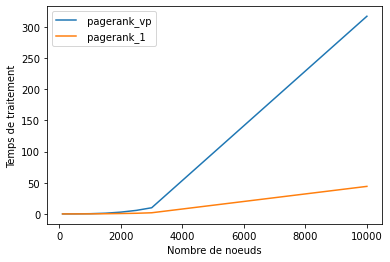

In [28]:
plt.plot(number_nodes,comparaison[0], label = " pagerank_vp")
plt.plot(number_nodes,comparaison[1], label = " pagerank_1")


plt.ylabel('Temps de traitement')
plt.xlabel('Nombre de noeuds')
plt.legend()

plt.show()

L'algorithme 1 ( astuce 1 ) est beaucoup moins couteux que l'algorithme de Page Rank par la décomposition en valeurs propres. 

### Etape 3 : Algorithme de PageRank astuce 2 

#### Algorithme 3:

Supposons que nous avons $1,...,n$ pages numérotées. Une page j est associée à un score $q_j$ mesurant son importance appelé PageRank. Il s'agit d'un nombre compris entre 0 et 1. Plus il sera proche de 1 plus son importance sera grande.

Le vecteur $q = (q_1,...,q_n)$ donne le score pour chacune des pages.

Il est implementé de la sorte:

$q = M^jP$

P correspond à une distribution de départ au début de la navigation et réalise j étape de navigation sur internet avec chaque action de M représentant le changement de distribution pour une étape. P peut être choisi de n'importe quelle façon tant qu'il s'agit d'une distribution de probabilité. On choisira ici une loi uniforme pour initialiser P:
$P = (1/n,...,1/n)$

La matrice M est définie de la façon suivante:

$M = sA + sD + tE$ 

où sA correspond à une navigation aléatoire, sD correspond au fait d'attérrir sur une page sans autre lien et tE correspond au fait de se "téléporter" à une page aléatoirement.

Nous choisirons s = 0.85 et t = 1-s = 0.15 pour les probabilités de choisir un lien au hasard et pour se "téléporter" respectivement. 

La matruce A décrit la structure du web. Nous définissons $\#(j)$ le nombre de liens depuis la page j. $A_{kj}$ sera 0 si la page j n'a pas de lien vers k et $1/\#(j)$ si la page j a un lien vers la page k. 

La matrice D est ajoutée pour prendre un compte les pages qui n'ont aucun lien vers d'autres sites. On choisit dans ce cas de prendre une page de façon uniformément aléatoire parmi toutes les pages. Si j est une page sans liensn la jème colonne de D devrait avoir toutes ses valeurs à 1/n sinon toutes les valeurs devraient être nulles.

Cela peut s'écrire de la sorte:

$D = ed^T/n$

où d est le vecteur représentant les pages sans lien (1 si pas de lien, 0 sinon) et e un vecteur ne contenant que des 1

Le dernier élements de M est la matrice E, qui décrit la téléportation vers un site au hasard. Cette matrice possède 1/n sur toutes ses valeurs representant une probabilité uniforme d'attérrir sur une autre page.

En manipulant naivement le vecteur de PageRank et n^2 éléments pour la matrice M, l'algorithme n'est pas très efficace. Pour éviter ceci, les matrices A, D et E ont une structure particulière. A est très sparse puisque la plupart des pages web n'ont de lien qu'avec une petite proportion de tout le web et la plupart de ses valeurs sont à 0. D n'est pas sparse mais a une structure simple determinée par un vecteur (pas une matrice) et d ce qui rend les multiplications impliquant D très simples à effectuer. Enfin, la matrice E est encore plus simple, il est assez immédiat d'implémenter les actions de E sur un vecteur.

L'algorithme ci-dessous va donc procéder de la sorte: implémentation de $M^jP$ en multipliant le vecteur P par M et à chaque multiplication, utilisation de la forme $M = sA+sD+tE$ pour éviter de garder en mémoire des vecteurs de dimension n. Il s'agit de l'étape `step` de l'algorithme ci-dessous qui permet d'implémenter le PageRank sur des millions de pages webs.

Le coeur de l'algorighme est donc de déterminer $(Mv)_j$ pour chaque indice j, où v est un vecteur arbitraire. 
On fait cela en implémentant $(Av)_j, (Dv)_j et (Ev)_j$ séparément et en additionnant ensuite les résultats avec les poinds s et t.

Pour implémenter $(Av)_j$, on note que $(Av)_j = \sum_k A_{jk} v_k$. On implémente donc cela en additionnant sur toutes les pages k qui ont un lien avec la page j, avec $A_{jk} = 1/\#(k)$ pour chaque cas. Le nombre total d'opérations pour implémenter Av est $\Theta(l)$, où l est le nombre total de liens dans le graphe web, bien inférieur à n^2. La mémoire requise est donc $\Theta(n)$.

Pour implémenter Dv, on note que $Dv = e (d\cdot v) /n$, pour implémenter le produit scalaire $d \cdot c$, le pire cas demanderait $\Theta(n)$ opérations et $\Theta(n)$ en mémoire pour stocker d.

Enfin, on implémente $(Ev)_j$ facilement puisque c'est simplement $(e \cdot v)/n$ , qui ne requiert pas de mémoire supplémentaire.

On peut alors implémenter Mv en utilisant un nombre total d'opértions $\Theta(n+1)$ et une mémoire totale $\Theta(n)$, ainsi on approxime le vecteur de PageRank $q \approx M^j P$

avec un nombre total d'opérations $\Theta(j(n+1))$, avec un coût en mémoire de $\Theta(n)$.

In [35]:
def step(g, PageRank, s=0.85):
    ''' Réalise une étape unique de PageRank à partir 
    d'une modélisation du web g et du paramètre s. Applique 
    la matrice correspondant M au vecteur p et retourne le
    vecteur résultant.'''
    n = g.size
    v = np.matrix(np.zeros((n,1)))
    inner_product = sum([PageRank[j] for j in g.dangling_pages.keys()])
    for j in range(n):
        v[j] = s*sum([PageRank[k]/g.number_out_links[k] for k in g.in_links[j]])+s*inner_product/n+(1-s)/n
    # On norme le vecteur de sortie pour qu'il reste une probabilité de distribution 
    return v/np.sum(v)

def pagerank_2(g, s=0.85, tolerance=0.00001):
    '''Deuxième algorithme de pagerank. Retourne le vecteur 
    pour la modélisation du web g et un paramètre s. Le critère
    de convergence est établi pour M^(j+1)P-M^jP de longueur
    inférieure à la tolérance, mesurée avec la norme l1.'''
    Start = time.time()
    n = g.size
    PageRank = np.matrix(np.ones((n,1)))/n #Initialisation du vecteur de PageRank
    iteration = 1
    change = 2
    while change > tolerance: # critère de convergence 
        new_p = step(g,PageRank,s) # utilisation de la fonction qui réalise une étape de PageRank unique
        change = np.sum(np.abs(PageRank-new_p)) # Calcul de la longueur entre M^(j+1)P-M^jP et la tolérance
        PageRank = new_p # Mise à jour de la matrice P
        iteration +=1
    End = time.time()
    return End - Start, PageRank

In [36]:
g = random_web(3000)
pr = pagerank_2(g,0.85,0.0001)

In [37]:
pr

(1.3905439376831055,
 matrix([[1.63496417e-04],
         [5.00000000e-05],
         [5.00000000e-05],
         ...,
         [1.53685977e-04],
         [5.00000000e-05],
         [5.00000000e-05]]))

#### Comparaison des algorithmes 2 et 3

#### Première façon de comparer

In [22]:
def compare_models2 (number_nodes) : 
    l_pagerank_1 = []
    pagerank_2 = []
    for nodes in range (2,number_nodes) : 
        if nodes%100 == 0 : print("Traitement pour",nodes,"noeuds")
        g=random_web(nodes)
        l_pagerank_1.append(pagerank_1(g)[0])
        pagerank_2.append(pagerank(g)[0])
    return l_pagerank_1, pagerank_2

In [26]:
comparaison2 = compare_models2 (1000)

Traitement pour 100 noeuds
Traitement pour 200 noeuds
Traitement pour 300 noeuds
Traitement pour 400 noeuds
Traitement pour 500 noeuds
Traitement pour 600 noeuds
Traitement pour 700 noeuds
Traitement pour 800 noeuds
Traitement pour 900 noeuds


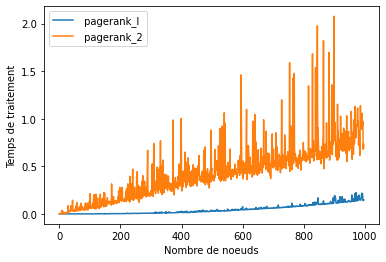

In [27]:
import matplotlib.pyplot as plt
plt.plot(comparaison2[0], label = " pagerank_l")
plt.plot(comparaison2[1], label = " pagerank_2")

plt.ylabel('Temps de traitement')
plt.xlabel('Nombre de noeuds')
plt.legend()

plt.show()

Pour un faible nombre de noeuds (en dessous de 1000), l'algorithme 3 est plus lent que l'algorithme 2.

**Comparaison avec 3000 noeuds**

In [ ]:
def compare_models2 (number_nodes) : 
    l_pagerank_1 = []
    l_pagerank_2 = []
    for nodes in range (2,number_nodes) : 
        if nodes%100 == 0 : print("Traitement pour",nodes,"noeuds")
        g=random_web(nodes)
        l_pagerank_1.append(pagerank_1(g)[0])
        l_pagerank_2.append(pagerank_2(g)[0])
    return l_pagerank_1, l_pagerank_2

In [26]:
comparaison2 = compare_models2 (3000)

Traitement pour 100 noeuds
Traitement pour 200 noeuds
Traitement pour 300 noeuds
Traitement pour 400 noeuds
Traitement pour 500 noeuds
Traitement pour 600 noeuds
Traitement pour 700 noeuds
Traitement pour 800 noeuds
Traitement pour 900 noeuds
Traitement pour 1000 noeuds
Traitement pour 1100 noeuds
Traitement pour 1200 noeuds
Traitement pour 1300 noeuds
Traitement pour 1400 noeuds
Traitement pour 1500 noeuds
Traitement pour 1600 noeuds
Traitement pour 1700 noeuds
Traitement pour 1800 noeuds
Traitement pour 1900 noeuds
Traitement pour 2000 noeuds
Traitement pour 2100 noeuds
Traitement pour 2200 noeuds
Traitement pour 2300 noeuds
Traitement pour 2400 noeuds
Traitement pour 2500 noeuds
Traitement pour 2600 noeuds
Traitement pour 2700 noeuds
Traitement pour 2800 noeuds
Traitement pour 2900 noeuds


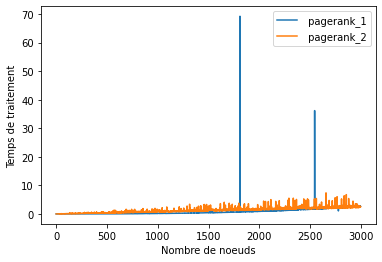

In [28]:
import matplotlib.pyplot as plt
plt.plot(comparaison2[0], label = " pagerank_1")
plt.plot(comparaison2[1], label = " pagerank_2")

plt.ylabel('Temps de traitement')
plt.xlabel('Nombre de noeuds')
plt.legend()

plt.show()

Pour un nombre de noeuds entre 1000 et 3000, les temps de traitement sont à peu près équivalents pour les deux algorithmes.

#### Deuxième façon de comparer algorithmes 2 et 3 plus rapide

In [12]:
def compare_models_2_3(number_nodes):
    l_pagerank_1 = []
    l_pagerank_2 = []
    for num in number_nodes:
        g = random_web(num)
        l_pagerank_1.append(pagerank_1(g)[0])
        l_pagerank_2.append(pagerank_2(g)[0])
    return l_pagerank_1, l_pagerank_2

In [13]:
number_nodes = [100, 1000, 3000, 5000, 10000]
comparaison2_3 = compare_models_2_3(number_nodes)

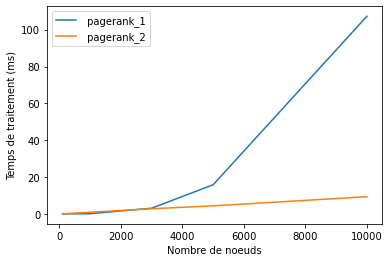

In [17]:
import matplotlib.pyplot as plt
plt.plot(number_nodes,comparaison2_3[0], label = " pagerank_1")
plt.plot(number_nodes,comparaison2_3[1], label = " pagerank_2")

plt.ylabel('Temps de traitement (ms)')
plt.xlabel('Nombre de noeuds')
plt.legend()

plt.show()

Pour un nombre de noeuds assez faible (inférieur à 3000), les performances des deux algorithmes sont équivalentes.

En revanche, lorsque l'on passe à un nombre de noeuds plus grand, l'algorithme 2 est beaucoup plus rapide. 
Pour 10000 noeuds par exemple, le deuxième algorithme est 10 fois plus rapide. 
Le deuxième algorithme est donc plus pertinent car dans le cadre d'une modélisation du web, le nombre de pages est très conséquent.

### Etape 4 : Algorithme de PageRank astuce 3 Map Reduce

Nous allons maintenant tenter d'implémenter une startégie mapreduce pour pouvoir diminuer encore plus les temps de calcul et permettre de traiter jusqu'à un million de noeuds.

Les entrées d'un alogorithme en mapreduce est un ensemble de couple (input_key, input_value). Chaque couple est utilisé comme entrée d'une fonction mapper(input_key, input_value) qui produit en sortie une liste de clés intermédaires et de valeurs intermédiaires:

La sortie des différents couples est ensuite triée pour que les valeurs intermédiaires associées à une même clé sont regroupées dans une liste de valeurs intermediaires. 

La fonction reducer(intermediate_key, intermediate_value_list) est ensuite appliquée à toute clé intermediaire et liste de valeurs intermediaires pour produire les sorties du MapReduce.

**MapReduce appliqué au PageRank**

L'approche ici est d'utiliser l'algorithme de Mapreduce pour multiplier à répétition un vecteur par la matrice M décrite plus haut. En particulier, si p est une distribution de probabilité, il est simple d'implémenter Mp avec MapReduce. On peut donc implémenter $M^jP$ en appelant plusieurs fois MapReduce. Ces appels à MapReduce doivent être réalisés en série mais il est simple de paralléliser les jobs de MapReduce individuels. 

Pour implémenter Ap:
Pour les entrées de l'implémentation de MapReduce, nous utilisons des couples (key, value) où la clé est un nombre de pages web que nous appelerons j et la valeur contient différents élements décrivant la page, dont $p_j$, le nombre $\#(j)$ de pages sortantes et une liste [k_1,k_2,...] de pages avec lesquelles j est reliée. 

Pour chaque page $k_1$ liée à j, le mapper sort une paire key-value intermédiaire avec la clé intermediaire étant $k_1$ et la valeur est la contribution $p_j/\#(j)$ apportée au PageRank. Intuitivement, cela correspond à une personne surfant d'une page web à une autre de façon aléatoire et allant à la page $k_1$, avec une probabilité $p_j/\#(j)$ combinant la probabilité $p_j$ qu'il commence à la page j et la probabilité $p_j/\#(j)$ qu'il aille à la page $k_1$.

Entre les phases de map et de reduce, MapReduce récupère toutes les valeurs intermédiaires correspondant à toutes les clés intermédiaires k (la liste de toutes les probabilités d'aller ) la page k). Le reducer additionne toutes ces probabilités et le résultat est la deuxième entrée de la paire $(k, p_k')$, donnant ainsi les entrées de Ap.

Pour maintenant implémenter Mp il faut faire trois changements.

Le premier changement consiste à s'assurer de bien prendre en compte les pages sans lien (le terme sD). 

On utilise donc l'expression $D = e d^T/n$. Ainsi $Dp = e (d\cdot p)/n$ où $d \cdot p$ est le produit scalaire entre le vecteur d et p. Dp correspond donc à implémenter $d \cdot p$

On implémente $d \cdot p$ en utilsant un job de MapReduce que l'on fait tourner en premier. Il implémente le produit scalaire et l'introduit comme paramètre d'une seconde étape de MapReduce basée sur la description précédente. La première étape de Mapreduce utilise les mêmes entrées que la précédente étape de MapReduce: un ensemble de clés j correspondant aux pages et de valeurs décrivant ces pages; contenant la valeur pour $p_j$ et une description de liens sortants depuis la page j. Si la page j est sans liens, le mapper sort la paire intermédiaire (1, $p_j$), sinon il ne sort rien. Toutes els valeurs intermédiaires sont indentiques, le reducer agit simplement sur une grande liste et additionne toutes les valeurs $p_j$ pour les pages sans lien, ce qui donne le produit scalaire que nous souhaitions. 

Le second changement à réaliser est d'inclure une étape de téléportation. Cela peut se faire simplement en modifiant le reducer pour inclure une contribution de téléportation. 

Le troisième changement à réaliser prend en compte 
Le seul moyen qu'une page apparaisse en tant que clé intermédiaire est qu'elle soit liée à une autre page. Les pages sans liens n'apparaitront pas dans la liste de clés intermédaires et donc ne seront pas présentes dans l'étape de MapReduce. On modifie donc le mapper pour qu'il émette une paire supplémentaire de clé-valeur en sortie. S'il prend en entrées (j, valeur), il émet une clé intermédiaire et valeurs intermédaires comme décrit précédemment et une paire supplémentaire (j,0) qui représente une probabilité 0 d'aller à la page j. Ainsi, toutes les pages j apparaitront comme clés intermédiaires mais cela n'a pas d'impact sur la probabilité d'aller à la page j.

In [39]:
def map_reduce(i, mapper, reducer):
    intermediate = []
    for (key, value) in i.items():
        intermediate.extend(mapper(key,value))
    groups = {}
    for key, group in itertools.groupby(sorted(intermediate), lambda x: x[0]):
        groups[key] = list([y for x, y in group])
    return [reducer(intermediate_key, groups[intermediate_key]) for intermediate_key in groups]

In [40]:
def initialize(g):
    '''
    Adaptation du web pour l'algorithme Map Reduce 
    
    Input : 
       - g de class web 
        
    Output : 
        - i de type dictionnaire 
        
    Exemple :
        - g=random_web(10)
        - i = initialize(g)
        - i
        >>> {0: [0.1, 0, []],
             1: [0.1, 0, []],
             2: [0.1, 0, []],
             3: [0.1, 0, []],
             4: [0.1, 10, [3, 7, 6, 8, 2, 0, 1, 4, 9, 5]],
             5: [0.1, 1, [4]],
             6: [0.1, 0, []],
             7: [0.1, 10, [1, 5, 2, 0, 9, 4, 6, 7, 8, 3]],
             8: [0.1, 0, []],
             9: [0.1, 0, []]}
    
    '''
    i = {}
    for j in range(g.size): 
        i[j] = [1.0/g.size,len(g.in_links[j]),g.in_links[j]]
    return i

def ip_mapper(input_key, input_value):
    '''Incrémentation du produit scalaire entre le vecteur des pages 
    sans lien extérieur et le PageRank estimé. Les entrées sont les clés
    décrivant la page web et les données correspondant. Le mapper 
    retourne [(1,pagerank)] si la page n'a pas de liens extérieurs et rien sinon
    '''
    if input_value[1]==0:
        return [(1,input_value[0])]
    else:
        return []
    
def ip_reducer(input_key,input_value_list):
    '''Le reducer implémente le produit scalaire. Cette fonction
    additionne les pageranks de la valeur d'entrée input_value_list
    qui sont les PageRanks des pages sans liens extérieurs.
    '''
    return sum(input_value_list)

def pr_mapper(input_key,input_value):
    '''Mise à jour du PageRank. Prend en entrées une clé pour une page web,
    et une valeur comme décrit dans la fonction initialize. 
    Retourne une liste avec les liens extérieurs des pages comme clés,
    et les valeurs correspondantes
    '''
    return [(input_key,0.0)]+[(outlink,input_value[0]/input_value[1])
          for outlink in input_value[2]]
def pr_reducer_inter(intermediate_key, intermediate_value_list, s, ip, n):
    '''Cette fonction définit le reducer utilisé pour mettre à jour 
    la valeur de PageRank. 
    '''
    return (intermediate_key, s*sum(intermediate_value_list)+s*ip/n+(1.0-s)/n)

def pagerank_mr(i,s=0.85,tolerance=0.00001):
    '''Retourne le vecteur de PageRank d'une page web i avec 
    le paramètre s. Le critère de convergence définit l'arrêt 
    quand M^(j+1)P-M^jP a une longueur inférieure à la tolérance
    avec la norme l1
    '''
    Start = time.time()
    n = len(i)
    iteration = 1
    change = 2 # erreur initiale
    while change>tolerance:
        # Execute le job MapReduce utilisé pour implémenter le produit scalaire entre le vecteur des pages sans liens et incrémente la valeur de PageRank
        ip_list = map_reduce(i,ip_mapper,ip_reducer)
        # Au cas où il n'y a pas de pages sans liens extérieurs mapreduce retourne une liste vide
        # Sinon, retourne la liste de la fonction mapreduce.
        if ip_list == []:
            ip = 0
        else:
            ip = ip_list[0]
        pr_reducer = lambda x,y: pr_reducer_inter(x, y, s, ip, n)

        new_i = map_reduce(i,pr_mapper,pr_reducer)
        
        # Mise à jour de l'erreur
        change = sum([abs(new_i[j][1]-i[j][0]) for j in range(n)])
        
        # Mise à jour du vecteur de PageRank
        for j in range(n):
            i[j][0]= new_i[j][1]
        iteration +=1
    End = time.time()
    return End-Start, i

In [41]:
g=random_web(10)
i = initialize(g)
i

{0: [0.1, 6, [1, 9, 3, 4, 7, 5]],
 1: [0.1, 2, [4, 0]],
 2: [0.1, 1, [6]],
 3: [0.1, 0, []],
 4: [0.1, 0, []],
 5: [0.1, 2, [1, 4]],
 6: [0.1, 7, [7, 2, 0, 1, 8, 3, 9]],
 7: [0.1, 0, []],
 8: [0.1, 0, []],
 9: [0.1, 0, []]}

In [79]:
n = 10000 
g=random_web(n)
i = initialize(g)
new_i = pagerank_mr(i,0.85,0.0001)

In [80]:
new_i

(2.021047830581665,
 {0: [0.0002016349842951336, 0, []],
  1: [7.334897701865359e-05, 0, []],
  2: [9.903711570929232e-05, 0, []],
  3: [0.00018926260992641137, 0, []],
  4: [7.235405652019204e-05, 1, [9112]],
  5: [8.410710688897947e-05, 1, [7282]],
  6: [0.00014859645888004605, 0, []],
  7: [0.0001004818807094472, 1, [1081]],
  8: [9.42933835596189e-05, 0, []],
  9: [8.879296352127726e-05, 0, []],
  10: [0.00015530729777353628, 0, []],
  11: [6.613384960405955e-05, 0, []],
  12: [6.626594783748804e-05,
   15,
   [6291,
    3892,
    5167,
    5092,
    9045,
    5363,
    5751,
    6770,
    3651,
    7352,
    5640,
    4779,
    8837,
    5740,
    3283]],
  13: [0.00016370172546098492, 0, []],
  14: [7.409553342031215e-05, 1, [9568]],
  15: [6.627465430097216e-05, 3, [6107, 2807, 620]],
  16: [6.731595415342673e-05, 0, []],
  17: [0.00015569418412148198, 0, []],
  18: [7.841655039676426e-05, 0, []],
  19: [9.422580992192118e-05, 0, []],
  20: [7.1986355532685e-05, 2, [7149, 5697]]

In [69]:
number_nodes = [100, 1000, 3000, 5000, 10000]

def compare_models(n):
    l_pagerank_2 = []
    l_pagerank_mr = []
    for num in n:
        g = random_web(num)
        i = initialize(g)
        l_pagerank_2.append(pagerank_2(g)[0])
        l_pagerank_mr.append(pagerank_mr(i)[0])
    return l_pagerank_2, l_pagerank_mr

In [70]:
comparaison3 = compare_models (number_nodes)

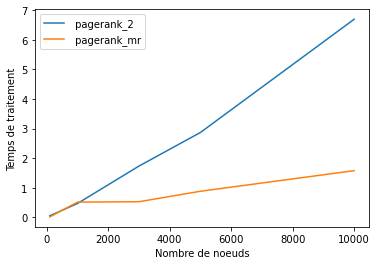

In [71]:
import matplotlib.pyplot as plt
plt.plot(number_nodes,comparaison3[0], label = " pagerank_2")
plt.plot(number_nodes,comparaison3[1], label = " pagerank_mr")

plt.ylabel('Temps de traitement')
plt.xlabel('Nombre de noeuds')
plt.legend()

plt.show()

### Application
On applique l'algorithme précédent à une base de données représentant les relations entre les différents avocats d'un cabinet du Nord-Est des Etats-Unis. Les deux graphes que nous allons étudier représentent pour l'un les relations amicales, et pour l'autre les demandes de conseils. 

In [78]:

# Chemin vers le dossier des bases de données
path_to_file = 'C:/Users/louis/OneDrive/Documents/ENSAE/3A/S2/Science des réseaux sociaux et économiques/Data_2Feb2022'

# Charger les bases de données
# Relations amicales 
ELfriendG = nx.read_edgelist(path_to_file+'/ELfriend_edgelist.txt', comments = "node", create_using=nx.DiGraph(),nodetype=int)
# Relations de conseils
ELadviceG = nx.read_edgelist(path_to_file+'/ELadvice_edgelist.txt', comments = "node", create_using=nx.DiGraph(),nodetype=int)
# Base de données supplémentaire comportant les attributs des avocats
ELnodes = pd.read_table(path_to_file+"/ELnodeAttributes.txt", sep='\t')
# Croisement des deux tables
ELNodeData = ELnodes.set_index('Node').to_dict('index').items()
ELfriendG.add_nodes_from(ELNodeData)
ELadviceG.add_nodes_from(ELNodeData)

Name: 
Type: DiGraph
Number of nodes: 71
Number of edges: 892
Average in degree:  12.5634
Average out degree:  12.5634


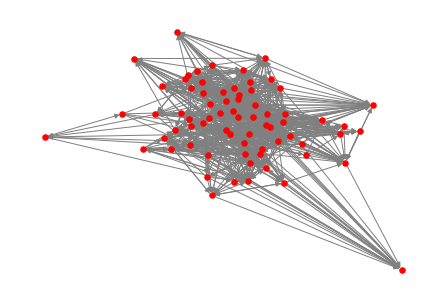

In [79]:
# Visualisation du graphe ELadviceG
print(nx.info(ELadviceG))
nx.draw(ELadviceG, with_labels=False, node_size=30, node_color="red", edge_color = "gray",
        pos=nx.fruchterman_reingold_layout(ELadviceG))

Name: 
Type: DiGraph
Number of nodes: 71
Number of edges: 575
Average in degree:   8.0986
Average out degree:   8.0986


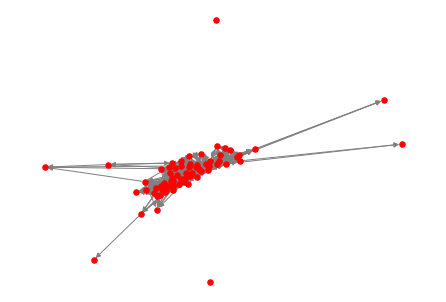

In [81]:
# Visualisation du graphe ELfriendG
print(nx.info(ELfriendG))
nx.draw(ELfriendG, with_labels=False, node_size=30, node_color="red", edge_color = "gray",
        pos=nx.fruchterman_reingold_layout(ELfriendG))

On remarque tout d'abord que deux avocats sont en dehors des relations amicales de cette entreprise.

In [37]:
def initialize_graph(G):
    '''
    Initialisation du graphe pour lui donner l'input attendu par l'algorithme Page Rank défini ci-dessus
    
    Input : 
        - G de type networkx.classes.digraph
        
    Output :
        - Dictionnaire de la forme { i : [poid du noeud i], nombre de noeuds sortant, [ liste des contacts de i ]} pour un noeud i
    
    Exemple :
        - i_friend = initialize_graph(ELfriendG)
        - i_friend
        >>> {0: [0.014084507042253521, 4, [2, 4, 8, 17]],
             1: [0.014084507042253521, 4, [16, 17, 22, 26]],
             2: [0.014084507042253521, 0, []],
             3: [0.014084507042253521, 15, [2, 3, 9, 11, 12, 14, 16, 17, 19, 21, 22, 23, 26, 27, 29]],
             ...
             66: [0.014084507042253521, 4, [68, 69, 70, 71]],
             67: [0.014084507042253521, 6, [41, 54, 56, 65, 70, 71]],
             68: [0.014084507042253521, 5, [66, 67, 68, 70, 71]],
             69: [0.014084507042253521, 7, [45, 64, 66, 67, 68, 69, 71]],
             70: [0.014084507042253521, 1, [64]]}
    
    '''
    adj_G = {int(k): [int(v[1]) for v in g] for k, g in groupby(sorted(G.edges()), lambda e: e[0])}
    i = {}
    for j in range(1,G.number_of_nodes()+1): 
        if j in adj_G : 
            i[j-1] = [1.0/G.number_of_nodes(),len(adj_G[j]),adj_G[j]]
        else : 
            i[j-1] = [1.0/G.number_of_nodes(),0,[]]
    return i

In [38]:
# Initialisation
i_friend = initialize_graph(ELfriendG)
i_advice = initialize_graph(ELadviceG)
# Application de l'algorithme Page Rank avec Map Reduce 
pagerank_friend = pagerank_mr(i_friend,0.85,0.0001)
pagerank_advice = pagerank_mr(i_advice,0.85,0.0001)
# Association du score Page Rank à chaque avocat 
score_advice ={ k : pagerank_advice[1][k][0] for k in range(len(pagerank_advice[1])) }
score_friend ={ k : pagerank_friend[1][k][0] for k in range(len(pagerank_friend[1])) }

In [39]:
# Trions les différents scores
from collections import OrderedDict
sortedDict_friend = OrderedDict(sorted(score_friend.items(), key=lambda x: x[1]))

# De la même façon pour la base advice
from collections import OrderedDict
sortedDict_advice = OrderedDict(sorted(score_advice.items(), key=lambda x: x[1]))

In [40]:
print('Les cinq avocats les plus influents en terme de conseils sont :',list(sortedDict_advice)[::-1][:5], '\n'
'Les cinq avocats ayant le plus d\'influence dans les liens amicaux sont : ',list(sortedDict_friend)[::-1][:5])

Les cinq avocats les plus influents en terme de conseils sont : [17, 6, 26, 1, 34] 
Les cinq avocats ayant le plus d'influence dans les liens amicaux sont :  [26, 17, 9, 13, 11]


In [62]:
print('Avocat 26 : ', ELfriendG.nodes(data=True)[27])
print('Avocat 17 : ', ELfriendG.nodes(data=True)[18])

Avocat 26 :  {'Status': 1, 'Gender': 2, 'Office': 1, 'Senior': 13, 'Age': 47, 'Spec': 1, 'School': 1}
Avocat 17 :  {'Status': 1, 'Gender': 1, 'Office': 2, 'Senior': 18, 'Age': 45, 'Spec': 1, 'School': 2}


On remarque que deux avocats ont à la fois des scores Page Rank élevés pour les relations amicales et de conseils ( Les avocats 26 et 17 ). On peut supposer que ces deux avocats ont une place importante dans l'entreprise. A l'aide des attributs de la base de données supplémentaire, on remarque que ces deux avocats ont respectivement 13 et 18 années d'expérience dans ce cabinet. 

In [48]:
print("Classement Page Rank amitié, avocat 6 : ", list(sortedDict_friend)[::-1].index(6),'\n' "Classement Page Rank amitié, avocat 1 :", list(sortedDict_friend)[::-1].index(1), '\n Attributs :',  ELfriendG.nodes(data=True)[7] )

Classement Page Rank amitié, avocat 6 :  50 
Classement Page Rank amitié, avocat 1 : 41 
 Attributs : {'Status': 1, 'Gender': 1, 'Office': 2, 'Senior': 29, 'Age': 63, 'Spec': 2, 'School': 3}


L'avocat 6 se place à la seconde place dans les scores de l'algorithme de Page Rank pour les conseils, il se situe cependant en fin de classement pour les liens d'amitié. On peut supposer que cet individu a de l'expérience dans ce cabinet, mais n'a que très peu de lien d'amitié avec ses collégues. C'est peut être un avocat en fin de carrière, ayant tissé peu de liens avec ses jeunes collègue. Cela se confirme à l'aide de la base de données supplémentaire. En effet, cette personne de 63 ans a 29ans d'ancienneté dans cette entreprise (parmi les plus ancien collaborateurs). La situation est assez similaire pour l'avocat 1.

In [51]:
print(list(sortedDict_advice)[::-1].index(9), '\n  \n Attributs :',  ELfriendG.nodes(data=True)[10])

26 
  
 Attributs : {'Status': 1, 'Gender': 1, 'Office': 1, 'Senior': 25, 'Age': 53, 'Spec': 2, 'School': 3}


L'avocat 9 a de très bonnes relations amicales ( 3e plus haut score Page Rank), mais n'est pas le plus influent en terme de conseils ( il se situe dans le milieu du classement Page Rank). Il a pourtant de l'expérience dans ce domaine ( employé depuis 25 ans dans ce cabinet). On pourrait emettre l'hypothèse qu'il appartient a un domaine très précis, ne correspondant pas aux demandes d'informations de ces collègues, ou ayant un poste à responsabilité, et n'étant que peu disponible. Il faudrait obtenir plus d'informations pour comprendre les distinctions entre ces scores. 

### Conclusion 
Dans cette problématique du score Page Rank, le calcul distribué par Map Reduce nous a permis de diminuer considérablement le temps de traitement de cet algorithme. Avec cette alternative, il est maintenant possible de traiter des réseaux comprenant des dizaines de milliers de liens, impensable avec le premier algorithm de Page Rank utilisant la décomposition en valeurs propres et vecteurs propres. 

La comparaison des modèles effectuée dans ce rapport n'est pas optimale. En effet, nous prenons simplement en compte ici le nombre de noeuds d'un réseau. Le nombre de liens peut lui aussi impacter la complexité du réseau, il n'est cependant pas pris en compte dans cette analyse ( le nombre de liens est aléatoire). 

Cet algorithm, initialement développé par Google pour classer les pages webs, peut également être utilisé pour analyser les liens sociaux, comme nous avons pu le voir dans la partie Application de ce travail. 

### Bibliographie :
https://snap.stanford.edu/class/cs224w-readings/Brin98Anatomy.pdf
http://lintool.github.io/MapReduceAlgorithms/MapReduce-book-final.pdf
https://michaelnielsen.org/blog/lectures-on-the-google-technology-stack-1-introduction-to-pagerank/
https://hippocampus-garden.com/pagerank/
https://sites.math.northwestern.edu/~clark/354/2002/perron.pdf
https://medium.com/analytics-vidhya/how-google-search-works-page-rank-algorithm-using-python-9643d9c9a981
https://towardsdatascience.com/pagerank-3c568a7d2332
https://michaelnielsen.org/blog/using-mapreduce-to-compute-pagerank/
https://michaelnielsen.org/blog/using-your-laptop-to-compute-pagerank-for-millions-of-webpages/
https://michaelnielsen.org/blog/write-your-first-mapreduce-program-in-20-minutes/